# Instananeous phase synchrony with real data

Import some needed libraries

In [4]:
import numpy as np
import pandas as pd

import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.2)

## Load and Convert Data
This is a fairly expensive way of loading the data into a pandas dataframe. Only do once and pickle it. Takes the original data printout from Karina and converts it into a pandas dataframe for easier manipulation.

In [129]:
with open("data/raweeg_fixed.json") as fp:
    a = json.load(fp)
    
sf = 400.0                       # Sampling frequency (Hz)
N = len(a[0]["samples"][0])              # Number of sample points
T = 1.0/sf                       # Spacing (s)

# This data is split into 256 sample chunks. Let's combine it into a homogenous collection
for chunk in a:
    N = len(chunk["samples"][0])
    start = pd.to_datetime(chunk["setAt"])
    end = start + pd.Timedelta(T * N, unit="s")
    index = pd.date_range(start, end, N);

    # d = {"datetime": index, 0: chunk["samples"][0]}
    d = dict(enumerate(chunk["samples"]))
    d["index"] = index
    dfchunk = pd.DataFrame(d)
    df = df.append(dfchunk)

df = df.set_index("index")

df.to_pickle("eeg_data.pik")

1259396


## Raw data plot (30s sample)

/home/david/dev/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Amplitude (mV?)'),
 (736800.8690645125, 736800.8694116327),
 Text(0.5, 0, 'Time'),
 Text(0.5, 1.0, '12000 sample points from 4 channels over 30 seconds')]

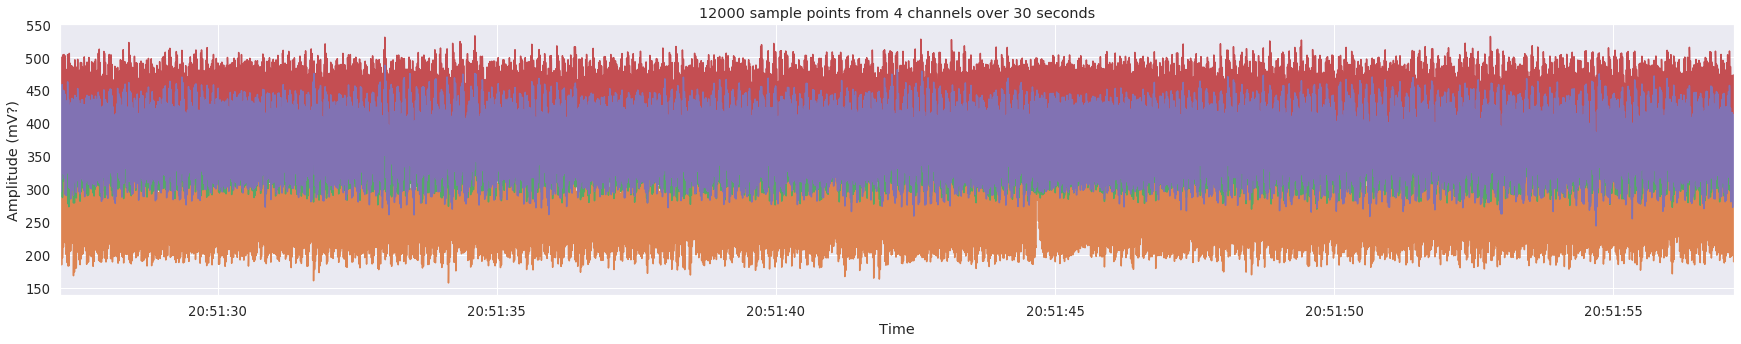

In [5]:
# Load the dataset from the pickle file so we don't have to import it all over again.
df = pd.read_pickle("eeg_data.pik")

sf = 400                       # Sampling frequency (Hz)
duration = 30                   # In seconds
start = 120000
samples = duration * sf
stop = start + samples
nchannels = len(df.iloc[0]) - 1

df_slice = df.iloc[start:stop]
fig, ax = plt.subplots(1,1,figsize = (30,5), sharex=True)
ax.plot(df_slice)
ax.set(title=f"{samples} sample points from {nchannels} channels over {duration} seconds", xlabel="Time", ylabel="Amplitude (mV?)", xlim=[min(df_slice.index), max(df_slice.index)])


## Spectral density of the signal

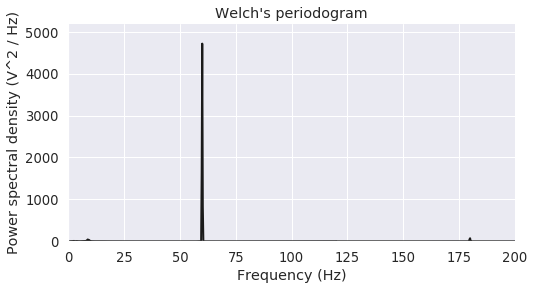

In [6]:
from scipy import signal

sf = 400                       # Sampling frequency (Hz)
win = 4 * sf
freqs, psd = signal.welch(df_slice[0], sf, nperseg=win)

# Plot the power spectrum
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

## Spectral Density of the delta band

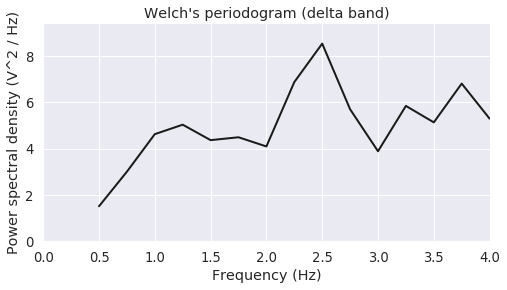

In [7]:
low, high = 0.5, 4

idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectrum
plt.figure(figsize=(8, 4))
plt.plot(freqs[idx_delta], psd[idx_delta], color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd[idx_delta].max() * 1.1])
plt.title("Welch's periodogram (delta band)")
plt.xlim([0, freqs[idx_delta].max()])
sns.despine()

## The hilbert synchrony function on two signals

Below is a function which calculated the synchrony using the hilbert transform.
In the future we will want this to return phase synchrony for all permutation of channel pairs

In [8]:
import numpy as np
from scipy.signal import hilbert

def hilbert_synchrony(y1,y2):
    al1 = np.angle(hilbert(y1),deg=False)
    al2 = np.angle(hilbert(y2),deg=False)
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    return phase_synchrony

Lets just make sure it works does what we expect...

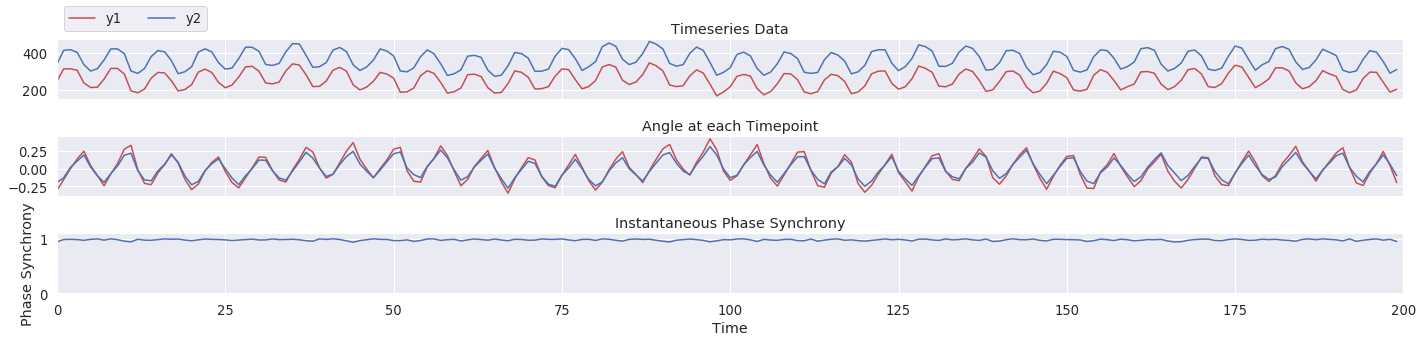

In [10]:
N = len(df_slice[:200])        # Samples
sf = 400                       # Sampling frequency (Hz)
T = 1.0/sf                  # sample spacing

y1 = df_slice[0][:200].values
y2 = df_slice[1][:200].values

al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)

f,ax = plt.subplots(3,1,figsize=(20,5),sharex=True)
ax[0].plot(y1, color='r', label='y1')
ax[0].plot(y2, color='b', label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Timeseries Data')

ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(title='Angle at each Timepoint')

phase_synchrony = hilbert_synchrony(y1, y2)

ax[2].plot(phase_synchrony)
ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show()

    

## Synchrony on specific bands
Now lets explore computing phase synchrony on an extracted frequency band.
We want to declare a frequency and bandwidth which we want to compute synchrony on in a channel pair.

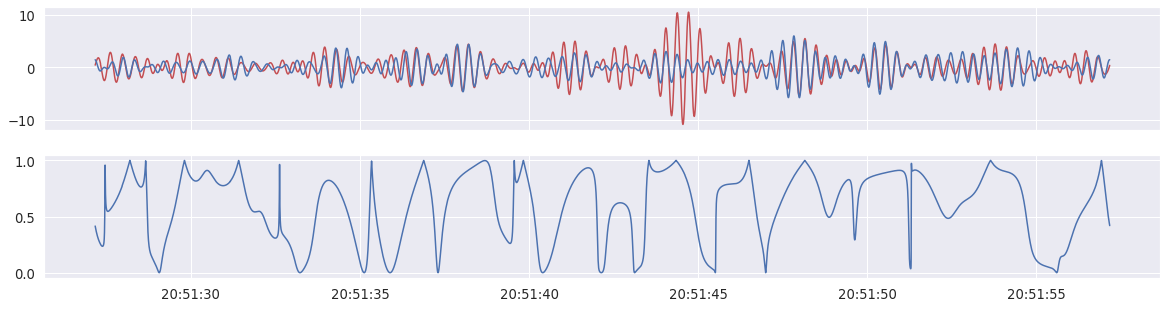

In [11]:
from scipy.fft import fft, ifft

N = len(df_slice)        # Samples
sf = 400                 # Sampling frequency (Hz)
T = 1.0/sf               # sample spacing

xf = np.linspace(0.0, 1/(2.0 * T),N//2)
y0_f = fft(df_slice[0].values)
y1_f = fft(df_slice[1].values)

frequency = 3                   # Hz
bandwidth = 1                   # Hz

band_max = frequency + bandwidth/2
band_min = frequency - bandwidth/2

idx_band = np.logical_and(xf >= band_min, xf < band_max)

idx_band = np.concatenate([idx_band, np.flip(idx_band)])
band_y0_f = np.where(idx_band, y0_f, np.zeros(N))
band_y1_f = np.where(idx_band, y1_f, np.zeros(N))

band_y0 = ifft(band_y0_f).real
band_y1 = ifft(band_y1_f).real

phase_synchrony = hilbert_synchrony(band_y0, band_y1)

fig, ax = plt.subplots(2,1,figsize=(20,5),sharex=True)
ax[0].plot(df_slice.index, band_y0, color='r',label='y0')
ax[0].plot(df_slice.index, band_y1, color='b',label='y1')

ax[1].plot(df_slice.index, phase_synchrony)


## Refactor into function
Now lets refactor this into a function parameterized by frequency, bandwidth, and sampling frequency

In [12]:
from scipy.fft import fft, ifft
from scipy.signal import hilbert
import numpy as np

def synchrony(y1, y2, frequency=3, bandwidth=1, sampling_frequency=400):
    N = len(y1)                 # Samples
    sf = 400                    # Sampling frequency (Hz)
    T = 1.0/sampling_frequency  # sample spacing

    xf = np.linspace(0.0, 1/(2.0 * T),N//2)
    y0_f = fft(y1)
    y1_f = fft(y2)

    band_max = frequency + bandwidth/2
    band_min = frequency - bandwidth/2

    idx_band = np.logical_and(xf >= band_min, xf < band_max)

    idx_band = np.concatenate([idx_band, np.flip(idx_band)])

    band_y0_f = np.where(idx_band, y0_f, np.zeros(N))
    band_y1_f = np.where(idx_band, y1_f, np.zeros(N))

    band_y0 = ifft(band_y0_f).real
    band_y1 = ifft(band_y1_f).real

    phase_synchrony = hilbert_synchrony(band_y0, band_y1)

    return phase_synchrony


Little helper function for plotting...

In [13]:
def plot_synchrony(df_slice, frequency, bandwidth, sampling_frequency=400):
    y0 = df_slice[0].values
    y1 = df_slice[1].values
    N = len(y1)                 # Samples
    sf = 400                    # Sampling frequency (Hz)
    T = 1.0/sampling_frequency  # sample spacing

    duration = N * T

    xf = np.linspace(0.0, 1/(2.0 * T),N//2)
    y0_f = fft(y0)
    y1_f = fft(y1)

    band_max = frequency + bandwidth/2
    band_min = frequency - bandwidth/2

    idx_band = np.logical_and(xf >= band_min, xf < band_max)

    idx_band = np.concatenate([idx_band, np.flip(idx_band)])

    band_y0_f = np.where(idx_band, y0_f, np.zeros(N))
    band_y1_f = np.where(idx_band, y1_f, np.zeros(N))

    band_y0 = ifft(band_y0_f).real
    band_y1 = ifft(band_y1_f).real
    
    fig, ax = plt.subplots(2,1,figsize=(20,5),sharex=True)

    phase_synchrony = hilbert_synchrony(band_y0, band_y1)

    fig.suptitle(f'Frequency {frequency}Hz - Bandwidth {bandwidth}Hz - {duration}s sample')
    ax[0].set(title='Amplitude', ylabel='Amplitude', xlim=[min(df_slice.index), max(df_slice.index)])    
    ax[0].plot(df_slice.index, band_y0, color='r',label='y0')
    ax[0].plot(df_slice.index, band_y1, color='b',label='y1')

    ax[1].set(title='Phase Synchrony', xlabel='Time', ylabel='Phase Synchrony', xlim=[min(df_slice.index), max(df_slice.index)])
    ax[1].plot(df_slice.index, phase_synchrony) 

## Some plots with real data
And now lets try a few different frequencies using the real data... These are all 30 second samples at various frequencies

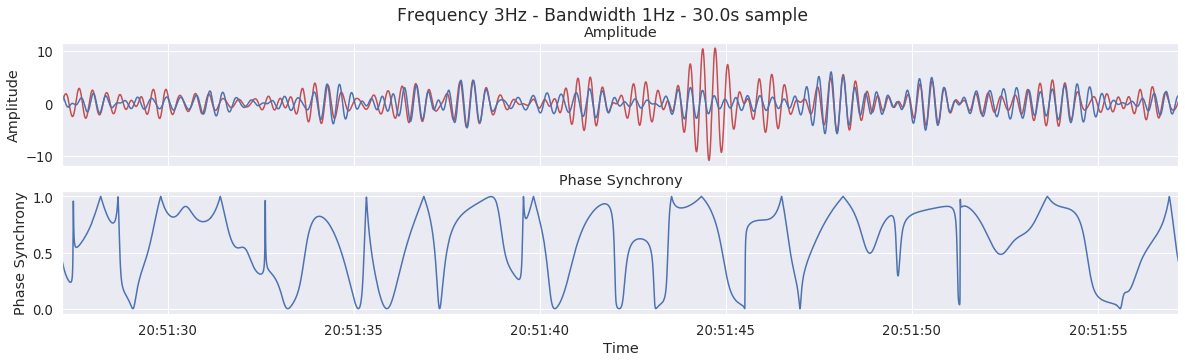

In [14]:
plot_synchrony(df_slice, 3, 1)

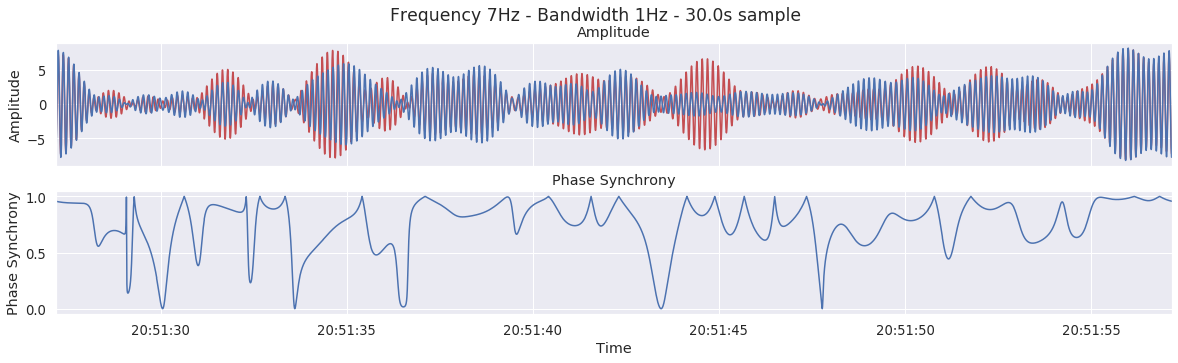

In [15]:
plot_synchrony(df_slice, 7, 1)

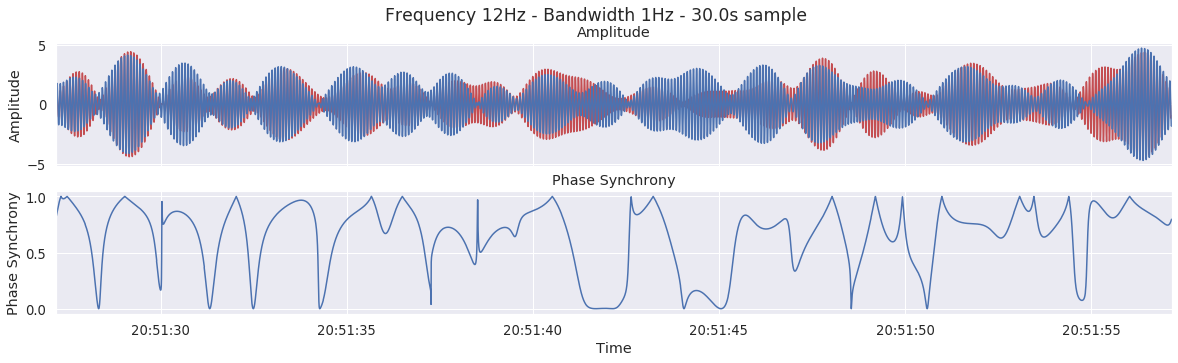

In [16]:
plot_synchrony(df_slice, 12, 1)

## 5 second sample
Lets see how synchrony performs with a much smaller window (5 seconds)

In [17]:
sf = 400                       # Sampling frequency (Hz)
duration = 5                   # In seconds
start = 120000
samples = duration * sf
stop = start + samples

df_small_slice = df.iloc[start:stop]

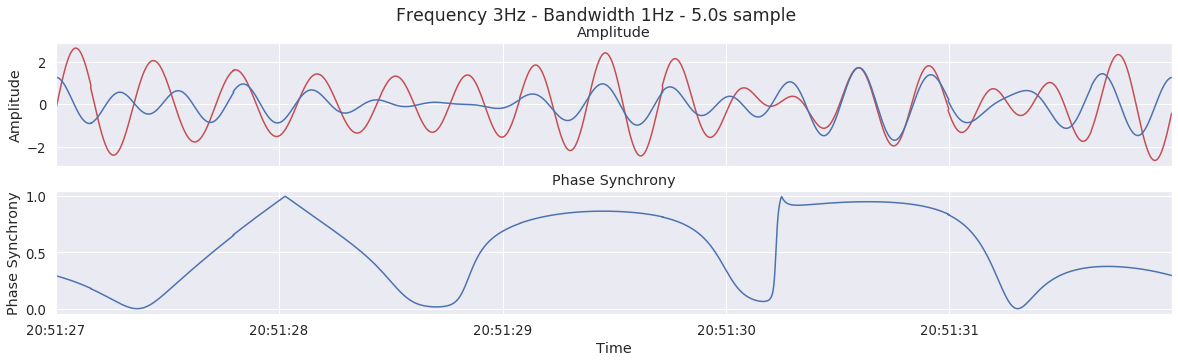

In [24]:
plot_synchrony(df_small_slice, 3, 1)

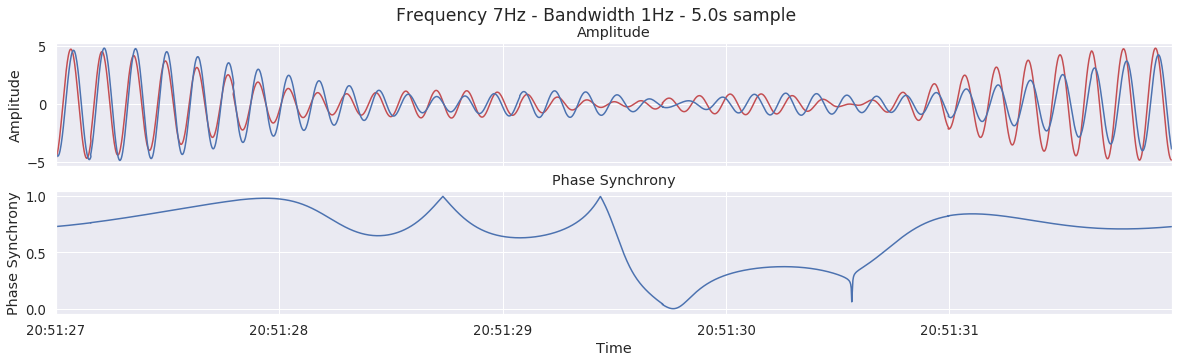

In [25]:
plot_synchrony(df_small_slice, 7, 1)

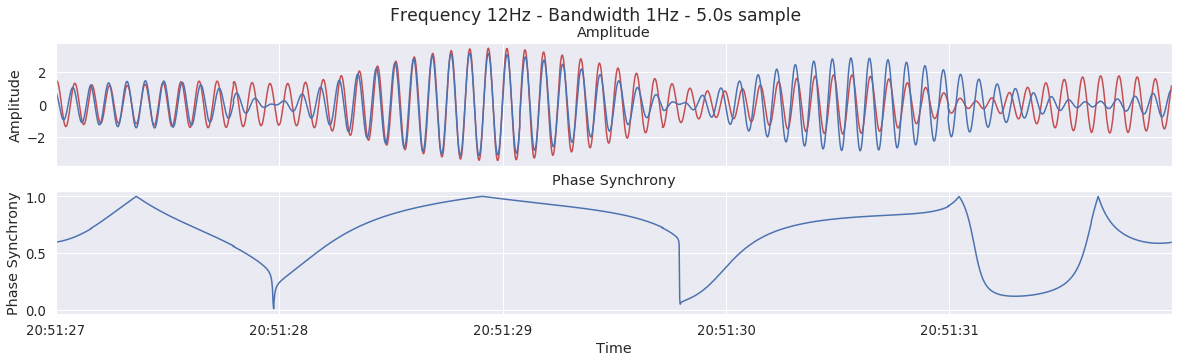

In [26]:
plot_synchrony(df_small_slice, 12, 1)

## 1 second sample
Lets see how synchrony performs with an smaller window (1 seconds)

In [27]:
sf = 400                       # Sampling frequency (Hz)
duration = 1                   # In seconds
start = 120000
samples = duration * sf
stop = start + samples

df_smaller_slice = df.iloc[start:stop]

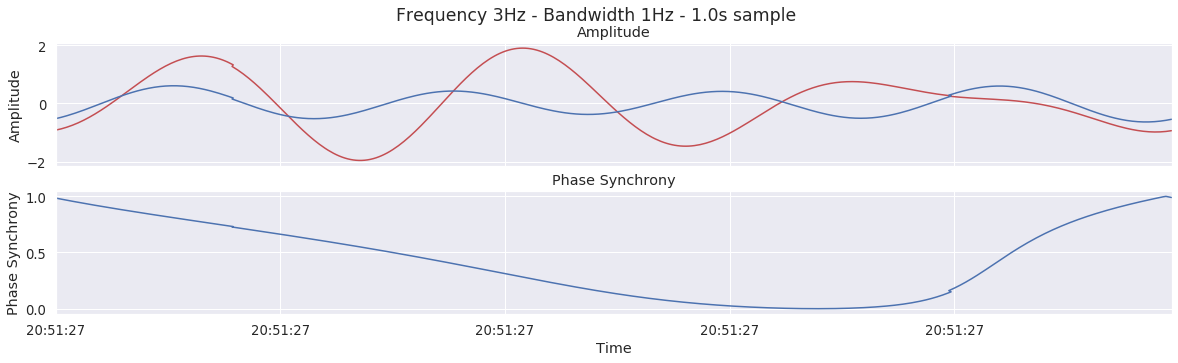

In [28]:
plot_synchrony(df_smaller_slice, 3, 1)

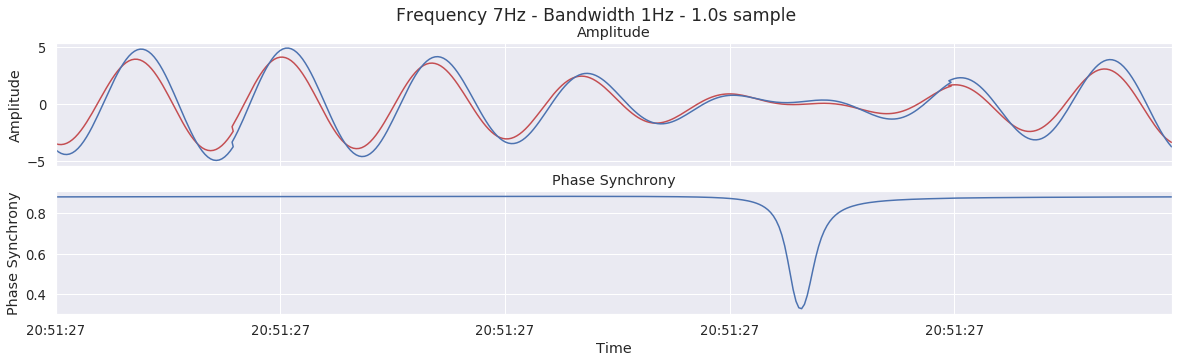

In [29]:
plot_synchrony(df_smaller_slice, 7, 1)

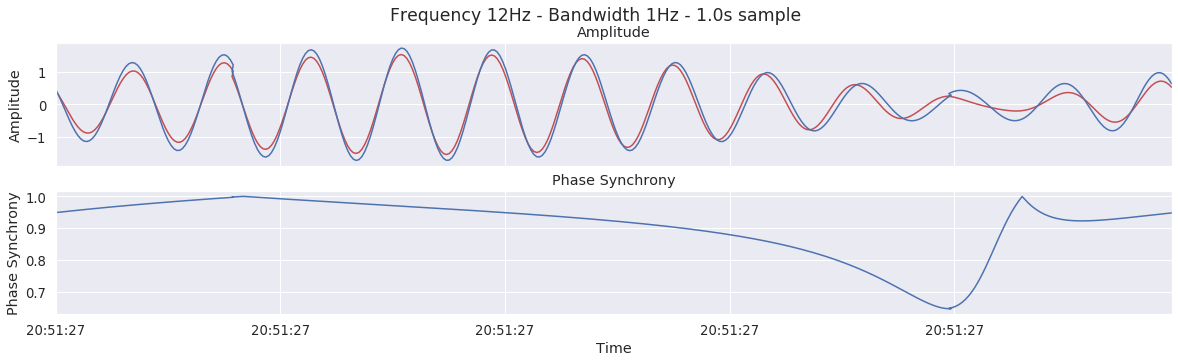

In [30]:
plot_synchrony(df_smaller_slice, 12, 1)